# Grain Level Stress and Strain Analysis
This notebook performs an analysis of simulated microstructures, combining stress/strain values for each voxel into values for each node (grain). The stress and strain values for each grain are fitted to a Generalized Extreme Value (GEV) distribution, and the parameters of these distributions are appended to the feature data.

In [1]:
import pandas as pd
from scipy.stats import genextreme
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

## Load and Preprocess the Data
The data includes two files: one that contains the grain level data, and another that contains the voxel level data. Each feature ID in the grain data corresponds to a grain, and each grain contains multiple voxels.

In [2]:
# Load the cell data
cell_data = pd.read_csv('CellData_FakeMatl_0.csv')

# Load the feature data
# Read the first line of the file to get the number of grains
with open('FeatureData_FakeMatl_0.csv', 'r') as f:
    num_grains = int(f.readline())

# Read the CSV file skipping the first line and only reading the number of lines equal to the number of grains
feature_data_part1 = pd.read_csv('FeatureData_FakeMatl_0.csv', skiprows=1, nrows=num_grains)

# Strip leading and trailing spaces from column names
cell_data.columns = cell_data.columns.str.strip()

print(feature_data_part1.head())

   Feature_ID  AspectRatios_0  AspectRatios_1  AvgQuats_0  AvgQuats_1  \
0           1        0.677188        0.571554   -0.409165   -0.403691   
1           2        0.747884        0.518182    0.239371   -0.617621   
2           3        0.431711        0.327166   -0.522351    0.209695   
3           4        0.796895        0.668670   -0.316150   -0.362567   
4           5        0.580899        0.410378    0.052344    0.216228   

   AvgQuats_2  AvgQuats_3  AxisEulerAngles_0  AxisEulerAngles_1  \
0    0.073722    0.814974           5.940952           1.136864   
1    0.384211    0.643139           0.850996           1.956397   
2   -0.821904    0.087473           1.912340           1.555136   
3    0.078427    0.873180           0.744444           1.858407   
4    0.956864    0.186862           1.942501           2.524663   

   AxisEulerAngles_2  ...  orientations_3  orientations_4  phases_conv  \
0           0.217851  ...        4.420462               1            1   
1         

## Calculate Mean Stress and Strain
We calculate the mean stress and strain values for each grain. We consider columns starting with 'E' in the cell data as strain, and columns starting with 'S' as stress.

In [3]:
# Identify the stress and strain columns
strain_cols = [col for col in cell_data.columns if col.startswith('E') and len(col) == 3]
stress_cols = [col for col in cell_data.columns if col.startswith('S') and len(col) == 3]

# Calculate the mean stress and strain for each grain
mean_strain = cell_data.groupby('FeatureIds')[strain_cols].mean()
mean_stress = cell_data.groupby('FeatureIds')[stress_cols].mean()

print(strain_cols)
print(stress_cols)

['E11', 'E12', 'E13', 'E22', 'E23', 'E33']
['S11', 'S12', 'S13', 'S22', 'S23', 'S33']


## Fit GEV Distribution and Extract Parameters
We fit a Generalized Extreme Value (GEV) distribution to these mean values and extract the distribution parameters (location, scale, and shape). We then append these parameters to the feature data.

The Generalized Extreme Value (GEV) distribution is a family of continuous probability distributions developed within extreme value theory to combine the Gumbel, Fr\Ă©chet and Weibull families also known as type I, II and III extreme value distributions. The GEV distribution is often used to model the maxima of other distributions.

The GEV distribution is defined as:

$$
F(x;\mu,\sigma,\xi) = \exp \left\{ - \left[ 1 + \xi \left( \frac{x - \mu}{\sigma} \right) \right]^{-1/\xi} \right\}, \quad \text{for } \xi \neq 0
$$

$$
F(x;\mu,\sigma,\xi) = \exp \left\{ - \exp \left[ - \left( \frac{x - \mu}{\sigma} \right) \right] \right\}, \quad \text{for } \xi = 0
$$

where $\mu$ is the location parameter, $ \sigma > 0 $ is the scale parameter, and $\xi$ is the shape parameter. The case where $\xi = 0$ corresponds to the Gumbel family.

We are using the method of moments to estimate these parameters. This method sets the moments of the theoretical distribution equal to the moments of the empirical distribution, and solves for the parameters of the theoretical distribution. For the GEV distribution, the method of moments estimates are:

- Shape parameter $\xi$: $0.5 - \text{sample skewness} / 6$
- Location parameter $\mu$: $\text{sample mean}$
- Scale parameter $\sigma$: $\text{sample standard deviation} * \(\sqrt{6}\) / \(\pi\)$

In [4]:
# Function to estimate GEV parameters
def estimate_gev_parameters(series):
    shape = 0.5 - skew(series) / 6
    loc = series.mean()
    scale = series.std() * (6**0.5) / np.pi
    return shape, loc, scale

# Initialize dataframes to hold the GEV parameters
gev_params_strain = pd.DataFrame(index=mean_strain.index,
                                 columns=[f"{col}_{param}" for col in strain_cols for param in ['shape', 'loc', 'scale']],
                                 dtype=float)
gev_params_stress = pd.DataFrame(index=mean_stress.index,
                                 columns=[f"{col}_{param}" for col in stress_cols for param in ['shape', 'loc', 'scale']],
                                 dtype=float)

# Estimate the GEV parameters for each grain
for grain_id in mean_strain.index:
    for col in strain_cols:
        params = estimate_gev_parameters(cell_data[cell_data['FeatureIds'] == grain_id][col].dropna())
        for param, value in zip(['shape', 'loc', 'scale'], params):
            gev_params_strain.loc[grain_id, f"{col}_{param}"] = value

for grain_id in mean_stress.index:
    for col in stress_cols:
        params = estimate_gev_parameters(cell_data[cell_data['FeatureIds'] == grain_id][col].dropna())
        for param, value in zip(['shape', 'loc', 'scale'], params):
            gev_params_stress.loc[grain_id, f"{col}_{param}"] = value

# Concatenate the GEV parameter dataframes with the feature data
feature_data_part1['Feature_ID'] = feature_data_part1['Feature_ID'].astype(int)
feature_data_part1_extended = pd.merge(feature_data_part1, gev_params_strain, left_on='Feature_ID', right_index=True)
feature_data_part1_extended = pd.merge(feature_data_part1_extended, gev_params_stress, left_on='Feature_ID', right_index=True)

C:\Users\Shamit\AppData\Local\Temp\ipykernel_10680\409878489.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  shape = 0.5 - skew(series) / 6


In [5]:
print(feature_data_part1_extended.head())

   Feature_ID  AspectRatios_0  AspectRatios_1  AvgQuats_0  AvgQuats_1  \
0           1        0.677188        0.571554   -0.409165   -0.403691   
1           2        0.747884        0.518182    0.239371   -0.617621   
2           3        0.431711        0.327166   -0.522351    0.209695   
3           4        0.796895        0.668670   -0.316150   -0.362567   
4           5        0.580899        0.410378    0.052344    0.216228   

   AvgQuats_2  AvgQuats_3  AxisEulerAngles_0  AxisEulerAngles_1  \
0    0.073722    0.814974           5.940952           1.136864   
1    0.384211    0.643139           0.850996           1.956397   
2   -0.821904    0.087473           1.912340           1.555136   
3    0.078427    0.873180           0.744444           1.858407   
4    0.956864    0.186862           1.942501           2.524663   

   AxisEulerAngles_2  ...  S13_scale  S22_shape      S22_loc   S22_scale  \
0           0.217851  ...  33.623621   0.512230  1173.642945   39.377969   
1     

## Visualize the Results
We create histograms of the GEV parameters for each stress variable to visualize their distributions.

['S11', 'S12', 'S13', 'S22', 'S23', 'S33']


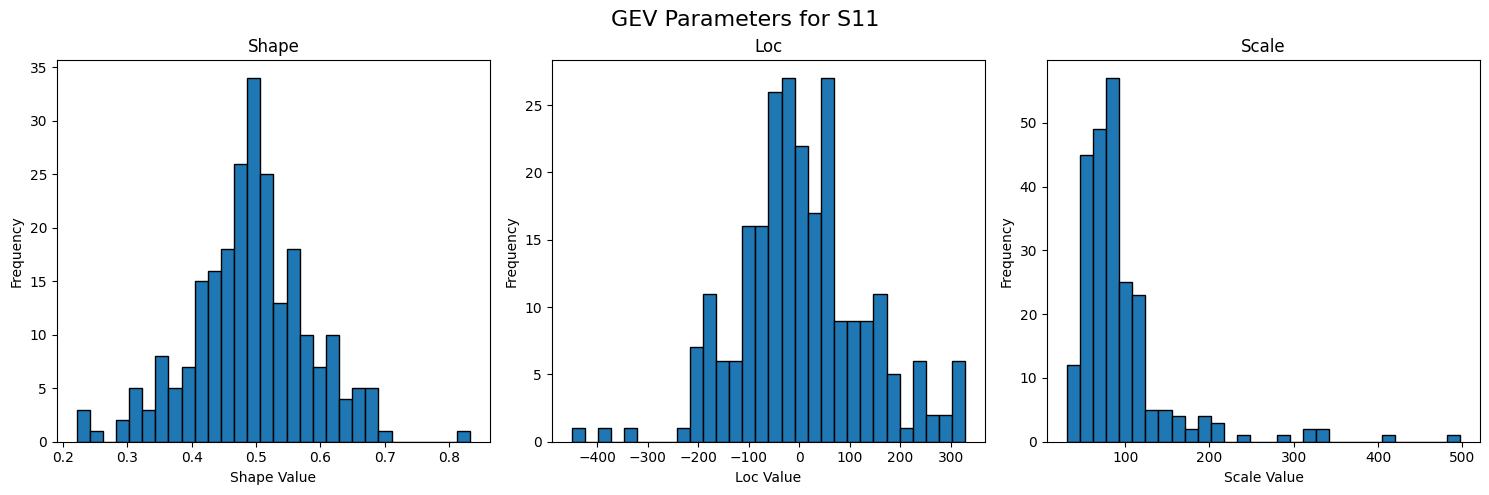

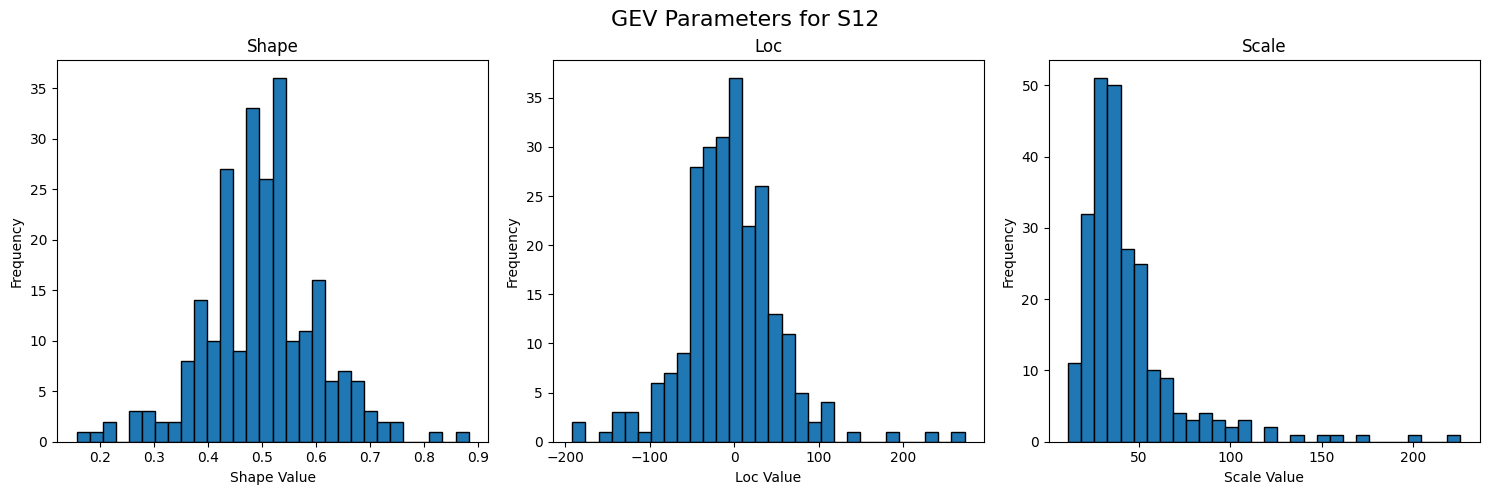

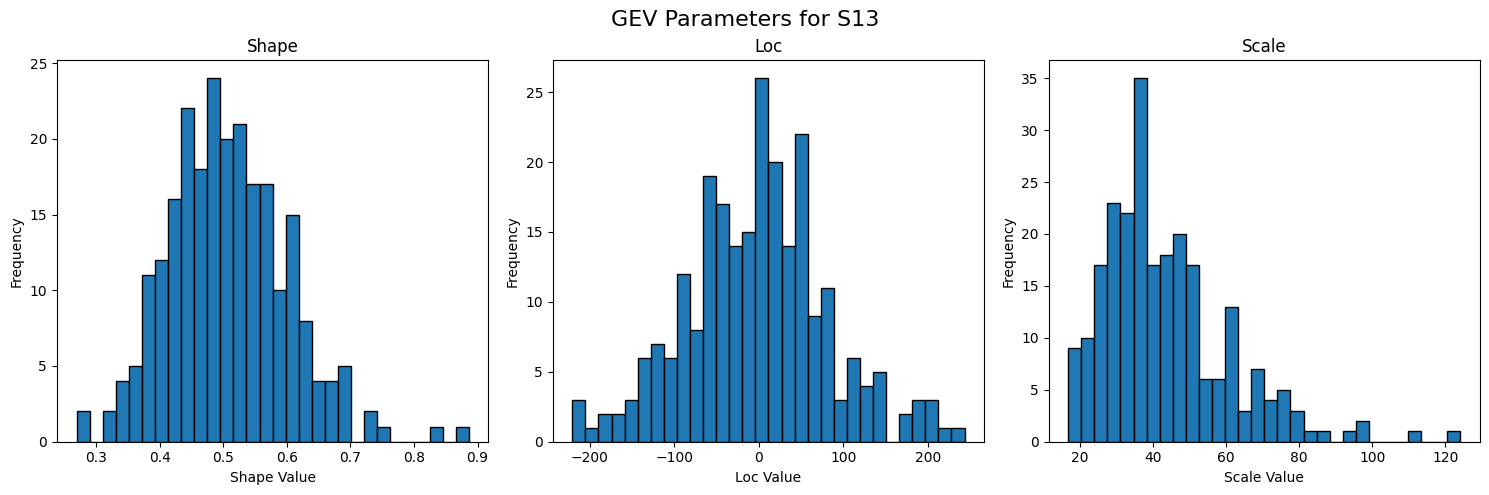

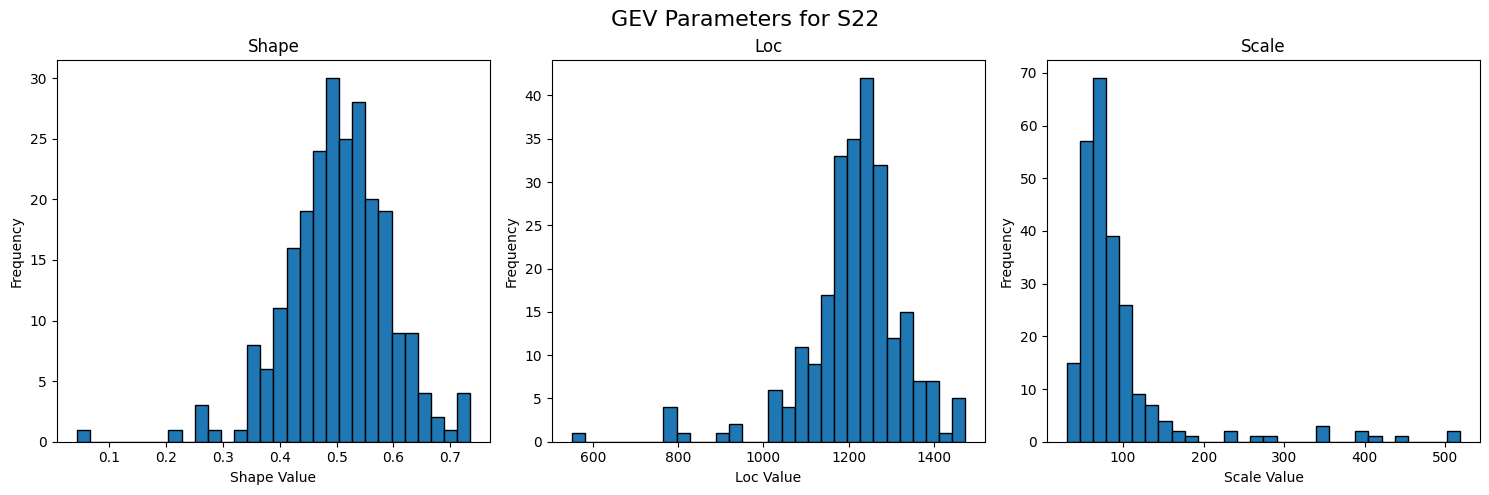

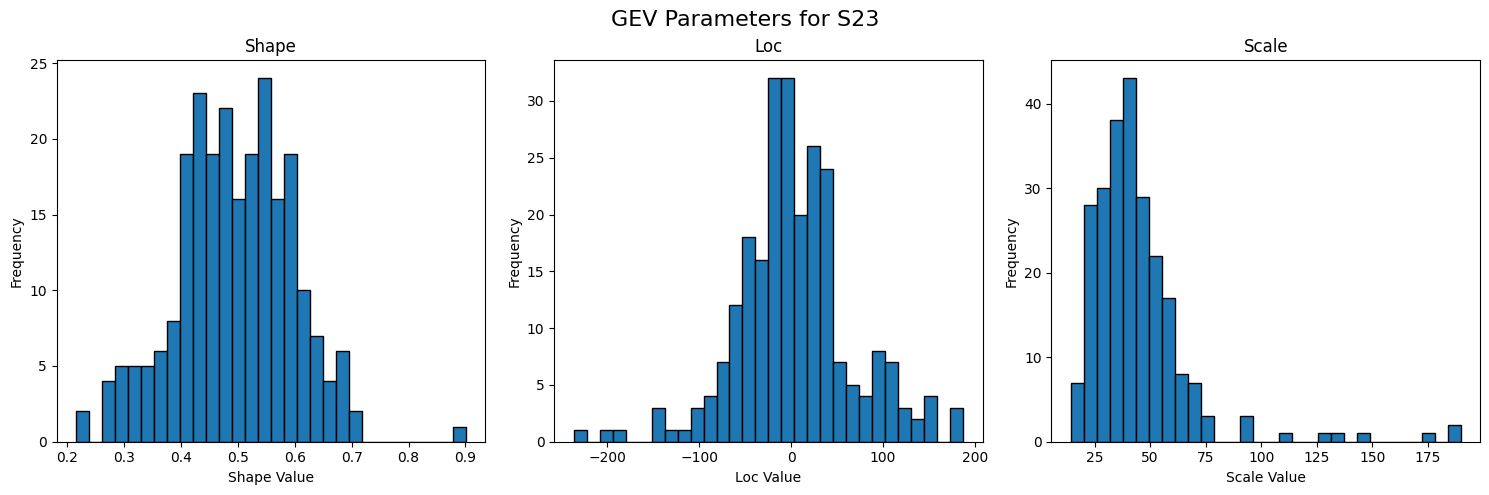

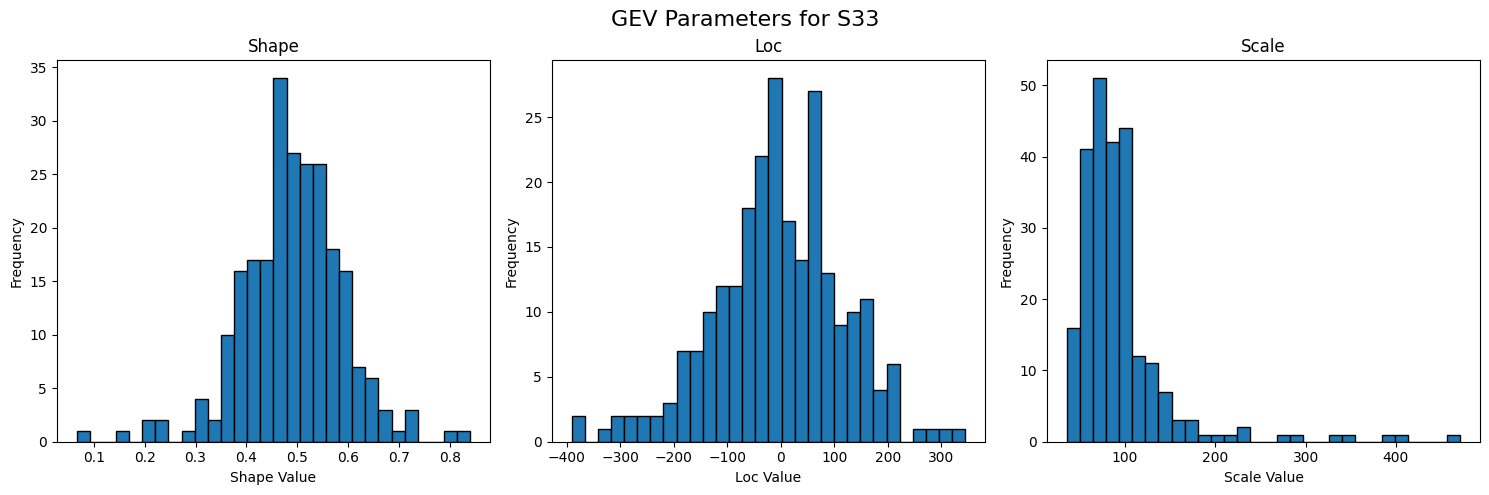

In [6]:
%matplotlib inline
# Create a list of parameters
params = ['shape', 'loc', 'scale']
print(stress_cols)
# Create plots for each stress variable
for col in stress_cols:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'GEV Parameters for {col}', fontsize=16)
    
    for i, param in enumerate(params):
        axs[i].hist(feature_data_part1_extended[f"{col}_{param}"].dropna(), bins=30, edgecolor='k')
        axs[i].set_title(f'{param.capitalize()}')
        axs[i].set_xlabel(f'{param.capitalize()} Value')
        axs[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

C:\Users\Shamit\AppData\Local\Temp\ipykernel_10680\190454065.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Grain ID')


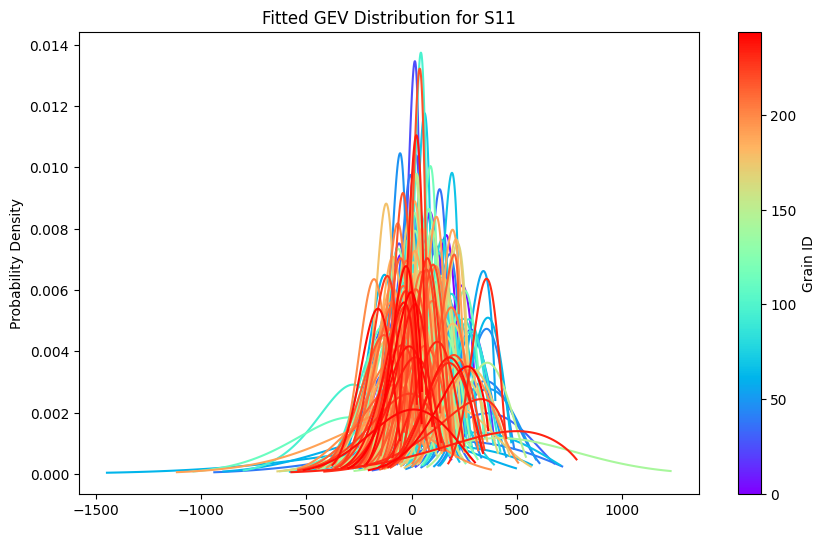

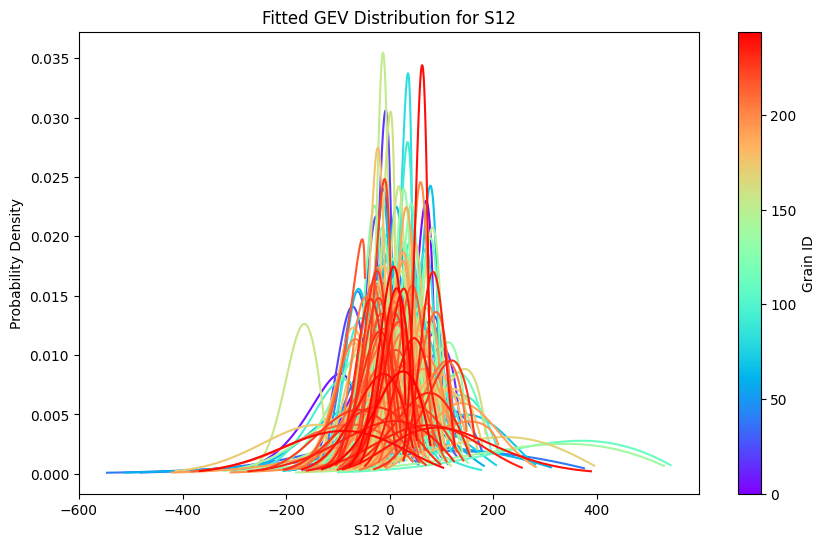

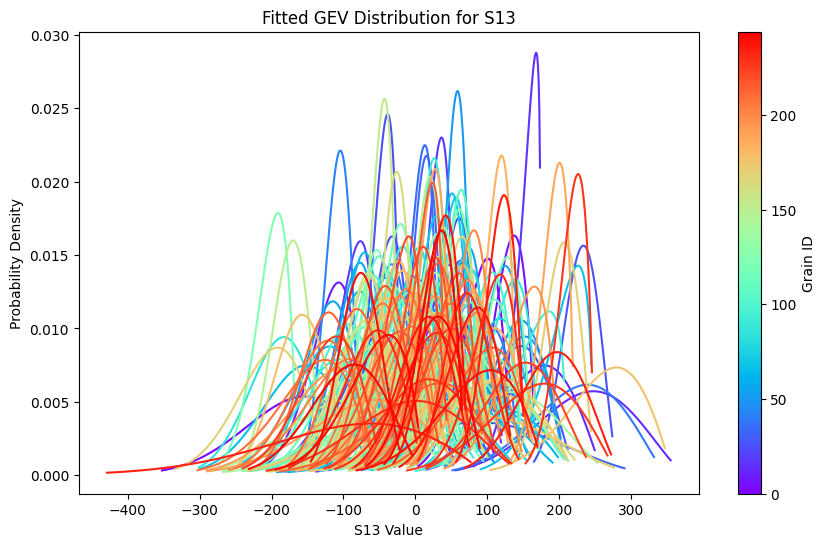

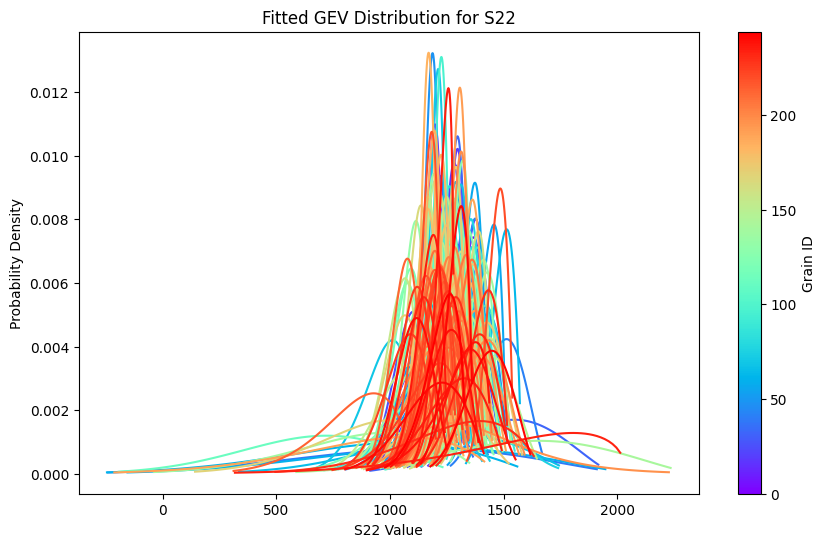

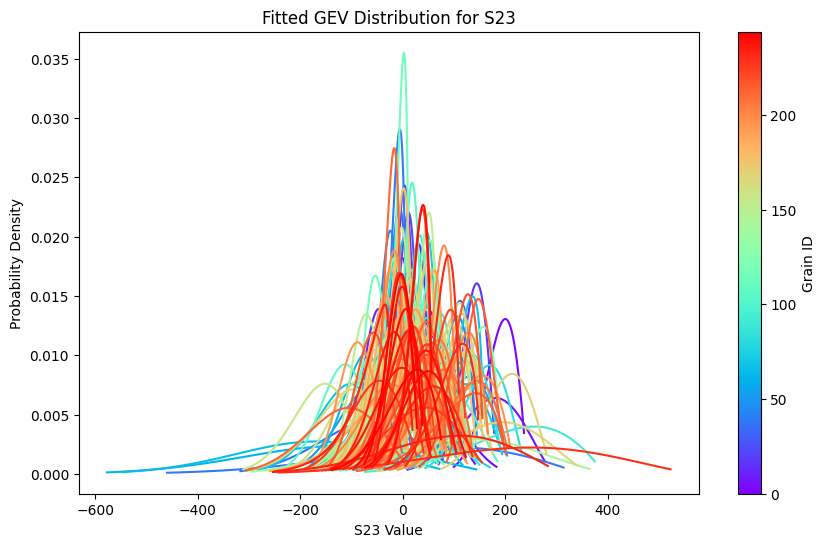

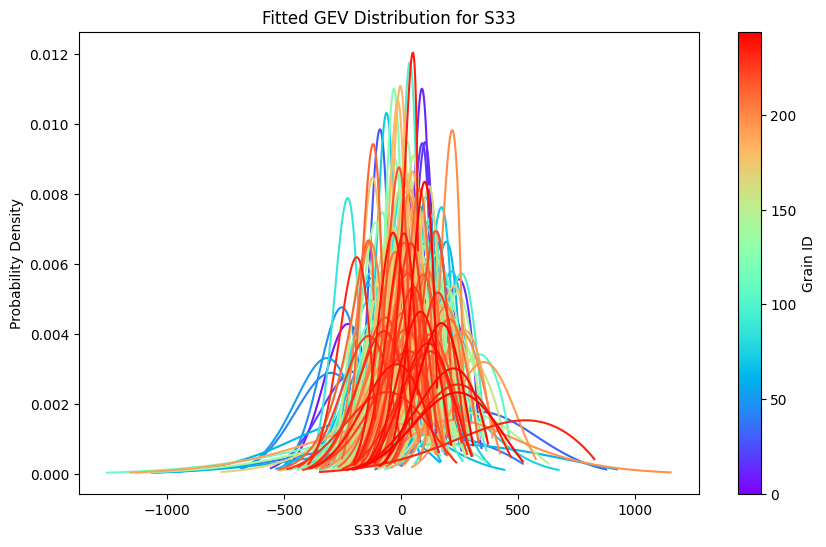

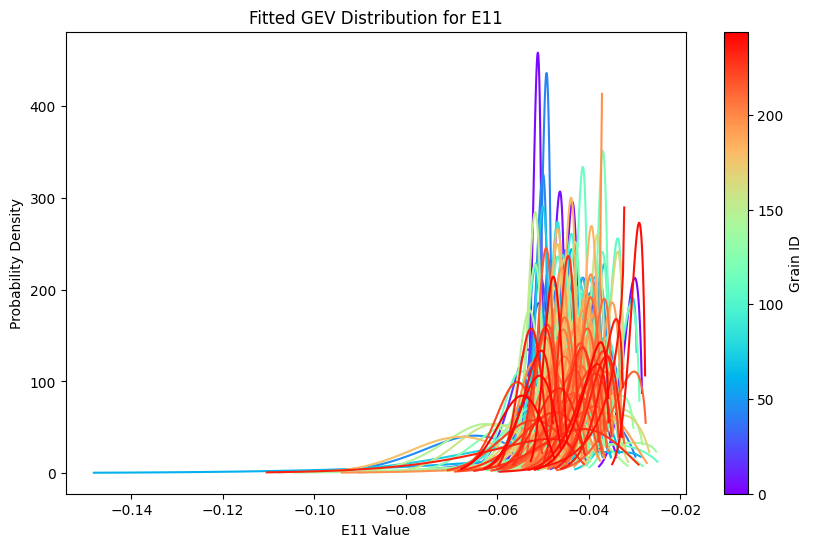

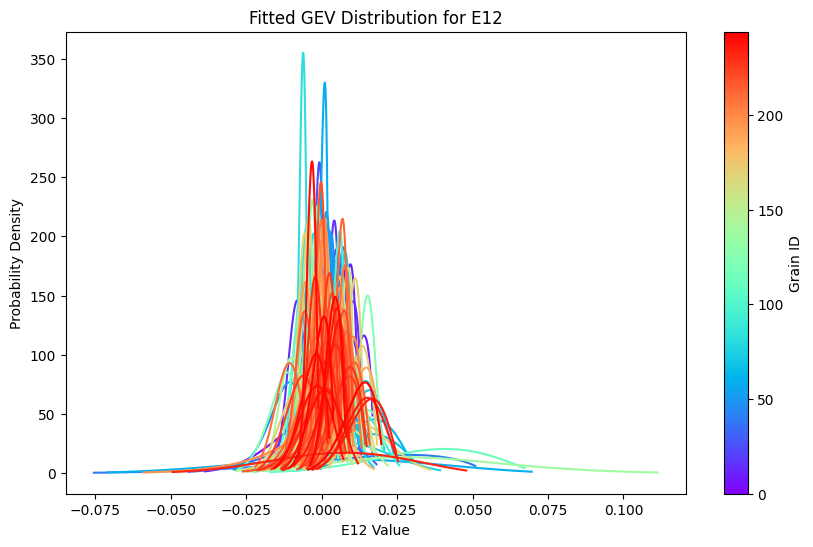

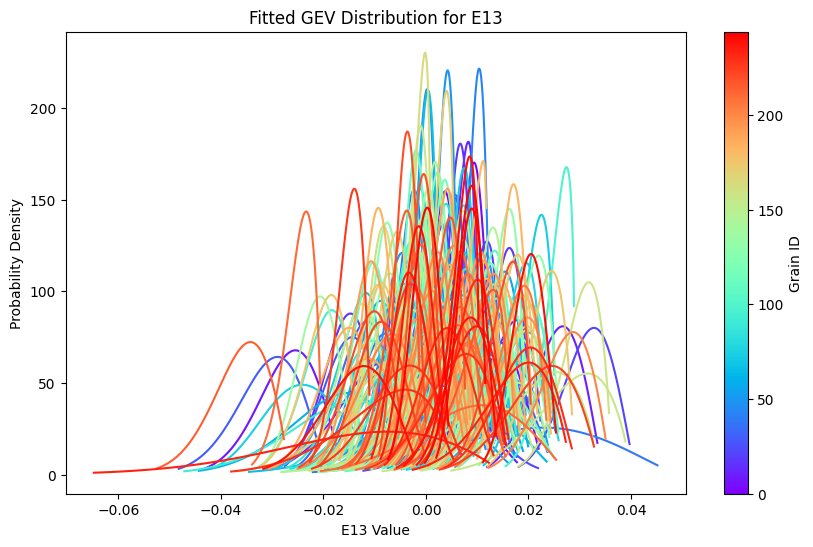

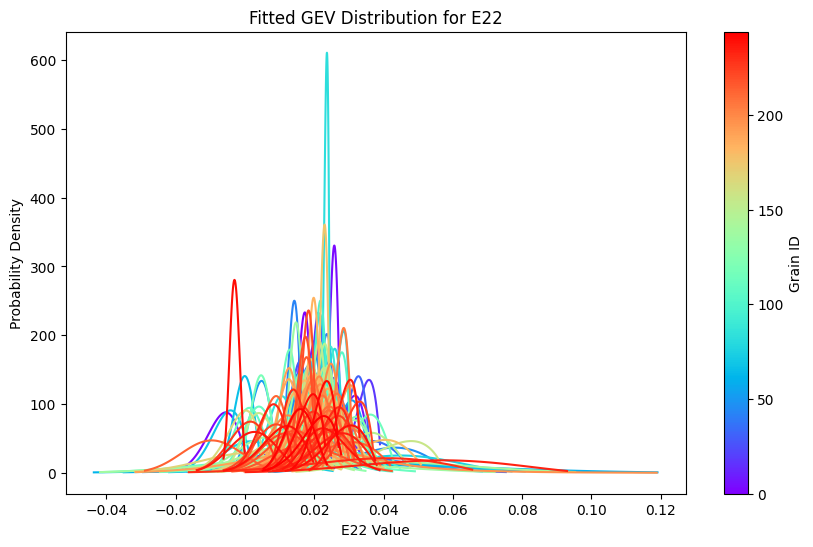

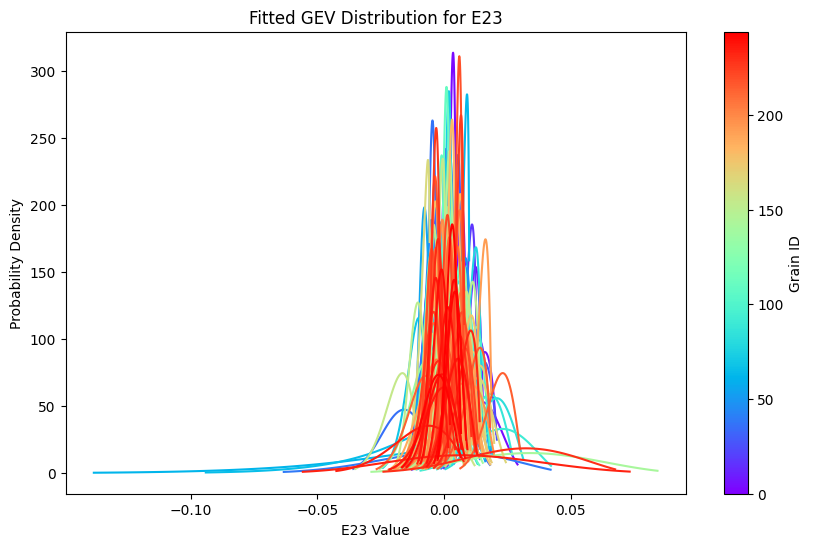

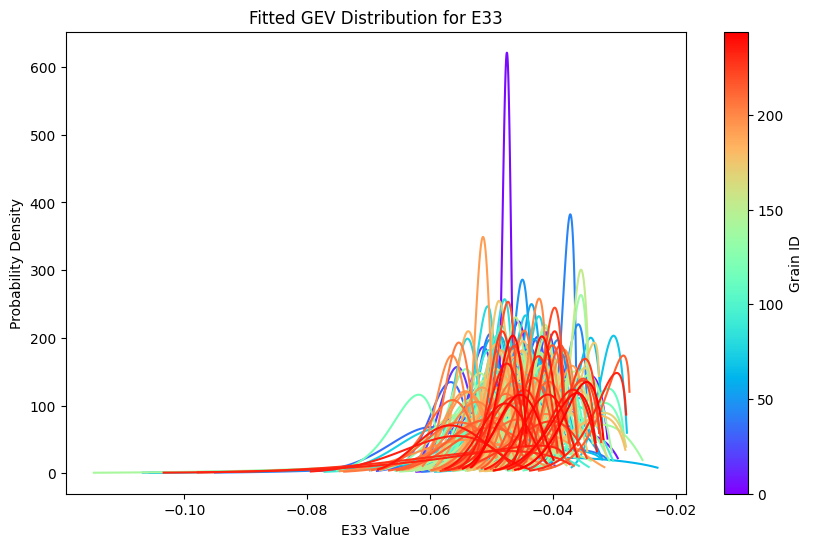

In [7]:
from scipy.stats import genextreme
import matplotlib.cm as cm

# GEV line plots
for col in stress_cols + strain_cols:
    plt.figure(figsize=(10, 6))
    plt.title(f'Fitted GEV Distribution for {col}')

    # Create a colormap
    grain_ids = feature_data_part1_extended.index.unique()
    colors = cm.rainbow(np.linspace(0, 1, len(grain_ids)))

    for grain_id, color in zip(grain_ids, colors):
        shape = feature_data_part1_extended.loc[grain_id, f'{col}_shape']
        loc = feature_data_part1_extended.loc[grain_id, f'{col}_loc']
        scale = feature_data_part1_extended.loc[grain_id, f'{col}_scale']
        x = np.linspace(genextreme.ppf(0.01, shape, loc, scale), genextreme.ppf(0.99, shape, loc, scale), 100)
        plt.plot(x, genextreme.pdf(x, shape, loc, scale), color=color)

    plt.xlabel(f'{col} Value')
    plt.ylabel('Probability Density')

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=cm.rainbow, norm=plt.Normalize(vmin=min(grain_ids), vmax=max(grain_ids)))
    plt.colorbar(sm, label='Grain ID')

    plt.show()

## Save the Results
Finally, we save the extended feature data to a new CSV file.

In [8]:
# Save the extended feature data to a new CSV file
feature_data_part1_extended.to_csv('extended_feature_data.csv', index=False)

# Alternative: Fit GEV Distribution using Maximum Likelihood Estimation
As an alternative to the method of moments, we can use the Maximum Likelihood Estimation (MLE) method to fit the GEV distribution and extract the parameters. This method often provides better estimates, but it requires numerical optimization and is more computationally intensive.

Please note that the following code can be computationally intensive and may take a while to run, especially with large datasets. You should only run it if you have sufficient computational resources.

In [9]:
# The following code is commented out due to its high computational demand. 
# Uncomment it if you want to run it on your local system with sufficient computational resources.

# Initialize dataframes to hold the GEV parameters
# gev_params_strain_mle = pd.DataFrame(index=mean_strain.index, 
#                                  columns=[f"{col}_{param}" for col in strain_cols for param in ['shape', 'loc', 'scale']],
#                                  dtype=float)
# gev_params_stress_mle = pd.DataFrame(index=mean_stress.index, 
#                                  columns=[f"{col}_{param}" for col in stress_cols for param in ['shape', 'loc', 'scale']],
#                                  dtype=float)

# Fit a GEV distribution to the mean values and extract the parameters using MLE
# for grain_id in mean_strain.index:
#    for col in strain_cols:
#        params = genextreme.fit(cell_data[cell_data['FeatureIds'] == grain_id][col].dropna())
#        for param, value in zip(['shape', 'loc', 'scale'], params):
#            gev_params_strain_mle.loc[grain_id, f"{col}_{param}"] = value

# for grain_id in mean_stress.index:
#    for col in stress_cols:
#        params = genextreme.fit(cell_data[cell_data['FeatureIds'] == grain_id][col].dropna())
#        for param, value in zip(['shape', 'loc', 'scale'], params):
#            gev_params_stress_mle.loc[grain_id, f"{col}_{param}"] = value

# Concatenate the GEV parameter dataframes with the feature data
# feature_data_part1_extended_mle = pd.merge(feature_data_part1_reset, gev_params_strain_mle, left_on='Feature_ID', right_index=True)
# feature_data_part1_extended_mle = pd.merge(feature_data_part1_extended_mle, gev_params_stress_mle, left_on='Feature_ID', right_index=True)